**Test**: Equal Number of Real News and Fake News from Global South, and checking PRA values.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install keras
!pip install tensorflo

ERROR: Could not find a version that satisfies the requirement tensorflo (from versions: none)
ERROR: No matching distribution found for tensorflo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import History

from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.layers import Embedding
from keras.layers import Reshape, Flatten
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D
from keras.layers import AveragePooling1D, Input, Dropout, concatenate

from wordcloud import WordCloud, STOPWORDS
import pickle
from keras.callbacks import EarlyStopping
# from sklearn import resample
from imblearn.over_sampling import SMOTE

### read data

In [ ]:
'''
This cell is primarily from global north
'''
# For ISOT Dataset
df1 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/Fake.csv', delimiter=',')
df2 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True_GN.csv', delimiter = ',')
# df1.head
df1['label'] = 0
df2['label'] = 1
# df_isot = pd.concat([df1.sample(500),df2.sample(500)])
df_isot = pd.concat([df1,df2])
# df_isot.columns
df = df_isot[['text','label']]
df.head()

# df = df_isot.sample(400)

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [ ]:
# Maximum number of words to be embedded
NUM_WORDS = 30000
EMBEDDING_DIM=100
# max length to be encoded for a sentence
MAX_SEQUENCE_LENGTH = 1000

# Define Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)

# Fit the function on the text
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

# pad the data to the same length
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 128136 unique tokens.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, df[['label']], test_size=0.2, random_state=42)

In [ ]:
print(y_train.shape)

(32020, 1)


In [ ]:
num_class_A_train = np.sum(y_train == 0)
num_class_B_train = np.sum(y_train == 1)
num_class_A_test = np.sum(y_test == 0)
num_class_B_test = np.sum(y_test == 1)
print(num_class_A_train)
print(num_class_A_test)
print(num_class_B_train)
print(num_class_B_test)

label    18800
dtype: int64
label    4681
dtype: int64
label    13220
dtype: int64
label    3324
dtype: int64


In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
num_class_A_train = np.sum(y_train == 0)
num_class_B_train = np.sum(y_train == 1)
num_class_A_test = np.sum(y_test == 0)
num_class_B_test = np.sum(y_test == 1)
print(num_class_A_train)
print(num_class_A_test)
print(num_class_B_train)
print(num_class_B_test)

label    18800
dtype: int64
label    4681
dtype: int64
label    18800
dtype: int64
label    3324
dtype: int64


### glove embedding

In [ ]:
word_vectors = dict()

# load the whole embedding into memory
f = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(word_vectors))

Loaded 400000 word vectors.


In [ ]:
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))
#vocabulary_size= len(word_index)+1
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
      # if the word is not found, set to all 0s
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i]=vec

#del(word_vectors)

In [ ]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
embedding_matrix.shape

(30000, 100)

In [ ]:
X_train.shape

(37600, 1000)

In [ ]:
# del(embedding_matrix)

### tokenized with LogisticRegression

In [ ]:
xtrain, xvald, ytrain, yvald = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

num_class_A_train = np.sum(ytrain == 0)
num_class_B_train = np.sum(ytrain == 1)
num_class_A_test = np.sum(yvald == 0)
num_class_B_test = np.sum(yvald == 1)
print(num_class_A_train)
print(num_class_A_test)
print(num_class_B_train)
print(num_class_B_test)

label    14965
dtype: int64
label    3835
dtype: int64
label    15115
dtype: int64
label    3685
dtype: int64


In [ ]:
epochs = 40
batch_size = 128
# xtrain, xvald, ytrain, yvald = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# xtrain = xtrain.astype('float64')
# xvald = xvald.astype('float64')
# ytrain = ytrain.astype('float64')
# yvald = yvald.astype('float64')

modelA = Sequential()
modelA.add(Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))

modelA.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
modelA.add(MaxPooling1D(4))
modelA.add(Dropout(0.3))

modelA.add(Flatten())
modelA.add(Dense(units = 128 , activation = 'relu'))
modelA.add(Dropout(0.3))
modelA.add(Dense(1, activation='sigmoid'))
modelA.summary()
modelA.compile(loss='binary_crossentropy',
              optimizer='Adadelta',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,          # Will print messages when early stopping triggers
                               mode='min',         # The direction is automatically inferred if not set but can be set to 'min' or 'max'
                               restore_best_weights=True)  # Whether to restore model weights from the epoch with the best value of the monitored quantity.

history = modelA.fit(xtrain, ytrain, validation_data = (xvald,yvald), epochs=epochs, verbose=1, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         3000000   
                                                                 
 conv1d (Conv1D)             (None, 997, 128)          51328     
                                                                 
 max_pooling1d (MaxPooling1  (None, 249, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 249, 128)          0         
                                                                 
 flatten (Flatten)           (None, 31872)             0         
                                                                 
 dense (Dense)               (None, 128)               4079744   
                                                        

In [ ]:
loss, pr, recall= modelA.evaluate(X_test, y_test)
print(pr)
print(recall)
print((2*pr*recall)/(pr + recall))

251/251 [==============================] - 1s 4ms/step - loss: 0.1036 - precision: 0.9486 - recall: 0.9780
0.948643147945404
0.978038489818573
0.963116576820689


In [ ]:
# define model
modelB = Sequential()
modelB.add(embedding_layer)
modelB.add(Flatten())
modelB.add(Dense(1, activation='sigmoid'))
# compile the model
modelB.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# summarize the model
modelB.summary()

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,          # Will print messages when early stopping triggers
                               mode='min',         # The direction is automatically inferred if not set but can be set to 'min' or 'max'
                               restore_best_weights=True)  # Whether to restore model weights from the epoch with the best value of the monitored quantity.

# fit the model
modelB.fit(xtrain, ytrain, validation_data = (xvald,yvald), epochs=epochs, batch_size=128, verbose=1, callbacks=[early_stopping])
# loss,accuracy = model.evaluate(X_test,y_test)
# print('Accuracy: %f' % (accuracy*100))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         3000000   
                                                                 
 flatten_1 (Flatten)         (None, 100000)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 100001    
                                                                 
Total params: 3100001 (11.83 MB)
Trainable params: 100001 (390.63 KB)
Non-trainable params: 3000000 (11.44 MB)
_________________________________________________________________
Epoch 1/40
235/235 [==============================] - 2s 4ms/step - loss: 0.2548 - precision_1: 0.9102 - recall_1: 0.9057 - val_loss: 0.1275 - val_precision_1: 0.9632 - val_recall_1: 0.9512
Epoch 2/40
235/235 [==============================] - 1s 4ms/step - loss: 0.0581 - 

In [ ]:
loss, pr, recall  = modelB.evaluate(X_test, y_test)
print(pr)
print(recall)
print((2*pr*recall)/(pr + recall))

251/251 [==============================] - 1s 3ms/step - loss: 0.0841 - precision_1: 0.9562 - recall_1: 0.9856
0.9562171697616577
0.9855595827102661
0.9706666779391442


### FNDNet

In [ ]:
num_kernels = 128
kernel_sizes= [3,4,5]
pool_sizes = [800,799,798]

#embed_input = Input(shape=(max_length,))
#x = Embedding(vocab_size,output_dim,input_length=max_length)(embed_input)

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embed_input = embedding_layer(inputs)

pool_outputs = []
for i in range(len(kernel_sizes)):
    conv = Conv1D(num_kernels, kernel_size=kernel_sizes[i], padding='valid', activation='relu')(embed_input)
    pool = MaxPooling1D(pool_size=pool_sizes[i], strides=1, padding = 'valid')(conv)
    pool_outputs.append(pool)
merge = concatenate(pool_outputs,axis = 1)

conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(merge)
pool = MaxPooling1D(pool_size=5)(conv)
conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(pool)
pool = MaxPooling1D(pool_size=30)(conv)

x = Flatten()(pool)
#x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)
modelC = Model(inputs=inputs,outputs=x)
modelC.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 100)            3000000   ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 998, 128)             38528     ['embedding[1][0]']           
                                                                                                  
 conv1d_2 (Conv1D)           (None, 997, 128)             51328     ['embedding[1][0]']           
                                                                                              

In [ ]:
modelC.compile(loss='binary_crossentropy',
              #optimizer='Adadelta',
              optimizer='Adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# from keras.utils import to_categorical

# # mapping = {'Real': 1, 'Fake': 0}
# # y_train['label'] = y_train['label'].map(mapping)
# # y_test['label'] = y_test['label'].map(mapping)

# y_train = to_categorical(np.asarray(y_train))
# y_test = to_categorical(np.asarray(y_test))

In [ ]:
epochs = 40
batch_size = 128
xtrain, xvald, ytrain, yvald = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,         # Number of epochs with no improvement after which training will be stopped
                               verbose=1,          # Will print messages when early stopping triggers
                               mode='min',         # The direction is automatically inferred if not set but can be set to 'min' or 'max'
                               restore_best_weights=True)  # Whether to restore model weights from the epoch with the best value of the monitored quantity.

# Fit the model with the early stopping callback
modelC.fit(xtrain, ytrain,
           epochs=epochs,
           validation_data=(xvald, yvald),
           batch_size=batch_size,
           verbose=1,
           callbacks=[early_stopping])

Epoch 1/40
235/235 [==============================] - 43s 164ms/step - loss: 0.1504 - precision_2: 0.9238 - recall_2: 0.9445 - val_loss: 0.0289 - val_precision_2: 0.9852 - val_recall_2: 0.9954
Epoch 2/40
235/235 [==============================] - 35s 151ms/step - loss: 0.0116 - precision_2: 0.9960 - recall_2: 0.9972 - val_loss: 0.0181 - val_precision_2: 0.9946 - val_recall_2: 0.9935
Epoch 3/40
235/235 [==============================] - 35s 150ms/step - loss: 0.0031 - precision_2: 0.9991 - recall_2: 0.9990 - val_loss: 0.0245 - val_precision_2: 0.9978 - val_recall_2: 0.9894
Epoch 4/40
235/235 [==============================] - 35s 150ms/step - loss: 0.0037 - precision_2: 0.9988 - recall_2: 0.9988 - val_loss: 0.0252 - val_precision_2: 0.9895 - val_recall_2: 0.9973
Epoch 5/40
235/235 [==============================] - 35s 149ms/step - loss: 0.0018 - precision_2: 0.9997 - recall_2: 0.9995 - val_loss: 0.0261 - val_precision_2: 0.9914 - val_recall_2: 0.9989
Epoch 5: early stopping


In [ ]:
loss, pr, recall  = modelC.evaluate(X_test, y_test)
print(pr)
print(recall)
print((2*pr*recall)/(pr + recall))

251/251 [==============================] - 4s 13ms/step - loss: 0.0171 - precision_2: 0.9931 - recall_2: 0.9952
0.9930951595306396
0.9951865077018738
0.9941397337375912


In [ ]:
# Save the trained model as a pickle string.
saved_model_path = 'modelA_saved_GN.pkl'
with open(saved_model_path, 'wb') as file:
    pickle.dump(modelA, file)

saved_model_path = 'modelB_saved_GN.pkl'
with open(saved_model_path, 'wb') as file:
    pickle.dump(modelB, file)

saved_model_path = 'modelC_saved_GN.pkl'
with open(saved_model_path, 'wb') as file:
    pickle.dump(modelC, file)

##Tests

In [ ]:
# Maximum number of words to be embedded
testbench_fni = pd.read_excel('/content/drive/MyDrive/Datasets_BTP/FNI/fakenewsincidents_india_dataset_v1.xls')
testbench_fni['label'] = 0
testbench_fni = testbench_fni[['Content', 'label']]
testbench_fni.columns = ['text', 'label']
testbench_fni.text=testbench_fni.text.astype(str)
print(testbench_fni.shape)
# testbench_fni = testbench_fni.sample(200)

testbench_ind = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/IND/IND_poli.csv')
testbench_ind['label'] = 1
# testbench_ind.columns
testbench_ind = testbench_ind[['News Abstract','label']]
testbench_ind.columns = ['text', 'label']
print(testbench_ind.shape)

t1 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/12-02-2024-Articles.csv')
t2 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/13-02-2024-Articles.csv')
t3 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/14-02-2024-Articles.csv')
t4 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/16-02-2024-Articles.csv')
t5 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/20-02-2024-Articles.csv')
t6 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/9-02-2024-Articles.csv')
t7 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/24-02-2024-Articles.csv')

testbench_toi = pd.concat([t1,t2,t3,t4,t5,t6,t7])
testbench_toi['label'] = 1
testbench_toi = testbench_toi[['text', 'label']]
testbench_gs_isot = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True_GS.csv', delimiter = ',')
testbench_gs_isot['label'] = 1
testbench_gs_isot = testbench_gs_isot[['text', 'label']]
print(testbench_toi.columns)
print(testbench_toi.shape)
testbench_gs = pd.concat([testbench_gs_isot, testbench_toi, testbench_ind, testbench_fni])
print(testbench_gs.shape)

sample_gn = 200
testbench_isot_fake = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/Fake.csv', delimiter=',')
testbench_isot_real = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True_GN.csv', delimiter = ',')
# testbench_isot_fake.head
testbench_isot_fake['label'] = 0
testbench_isot_real['label'] = 1
testbench_isot = pd.concat([testbench_isot_fake,testbench_isot_real])
testbench_isot_real.shape

(4802, 2)
(200, 2)
Index(['text', 'label'], dtype='object')
(584, 2)
(10459, 2)


(16544, 6)

###GN Data

In [ ]:
# modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_eq.pkl', 'rb'))
# modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_eq.pkl', 'rb'))
# modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_eq.pkl', 'rb'))

prStatsA = []
f1StatsA = []
reStatsA = []

prStatsB = []
f1StatsB = []
reStatsB = []

prStatsC = []
f1StatsC = []
reStatsC = []

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

tsample0 = testbench_isot_fake
tsample1 = testbench_isot_real
testbench_isot = pd.concat([tsample0,tsample1])

tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(testbench_isot['text'])
sequences = tokenizer.texts_to_sequences(testbench_isot['text'])
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

loss, pr, re = modelA.evaluate(data, testbench_isot[['label']])
prStatsA.append(pr)
f1StatsA.append((2*pr*re)/(pr+re))
reStatsA.append(re)

loss, pr, re = modelB.evaluate(data, testbench_isot[['label']])
prStatsB.append(pr)
f1StatsB.append((2*pr*re)/(pr+re))
reStatsB.append(re)

loss, pr, re = modelC.evaluate(data, testbench_isot[['label']])
prStatsC.append(pr)
f1StatsC.append((2*pr*re)/(pr+re))
reStatsC.append(re)

1251/1251 [==============================] - 15s 12ms/step - loss: 0.0075 - precision_2: 0.9973 - recall_2: 0.9978


In [ ]:
prA = []
f1A = []
reA = []

prB = []
f1B = []
reB = []

prC = []
f1C = []
reC = []

x = []

for i in range(10,100,5):
  train, test, trainLabel, testLabel = train_test_split(data, testbench_isot[['label']], test_size=(i/100), random_state=42)
  x.append(test.shape[0])
  loss, pr, re = modelA.evaluate(test, testLabel)
  prA.append(pr)
  f1A.append((2*pr*re)/(pr+re))
  reA.append(re)

  loss, pr, re = modelB.evaluate(test, testLabel)
  prB.append(pr)
  f1B.append((2*pr*re)/(pr+re))
  reB.append(re)

  loss, pr, re = modelC.evaluate(test, testLabel)
  prC.append(pr)
  f1C.append((2*pr*re)/(pr+re))
  reC.append(re)

1189/1189 [==============================] - 15s 12ms/step - loss: 0.0075 - precision_2: 0.9973 - recall_2: 0.9978


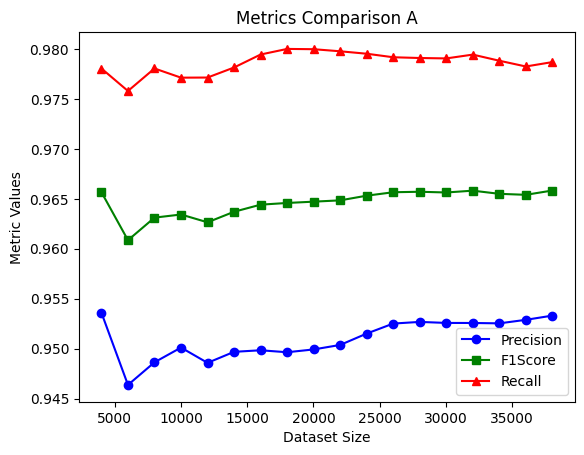

In [ ]:
plt.plot(x, prA, label='Precision', color='blue', marker='o')
plt.plot(x, f1A, label='F1Score', color='green', marker='s')
plt.plot(x, reA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

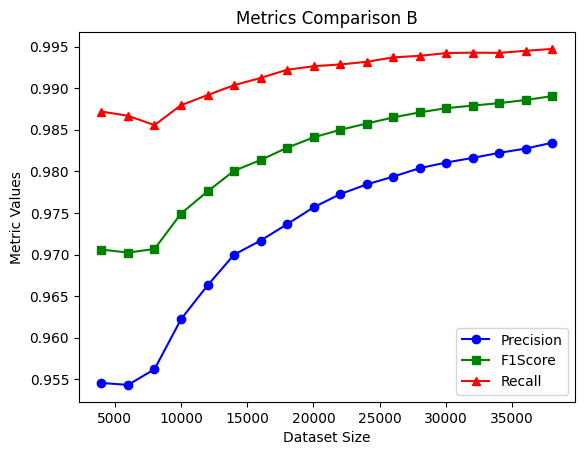

In [ ]:
plt.plot(x, prB, label='Precision', color='blue', marker='o')
plt.plot(x, f1B, label='F1Score', color='green', marker='s')
plt.plot(x, reB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

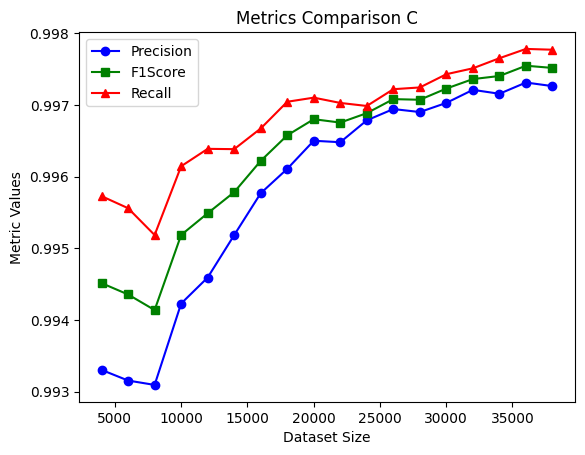

In [ ]:
plt.plot(x, prC, label='Precision', color='blue', marker='o')
plt.plot(x, f1C, label='F1Score', color='green', marker='s')
plt.plot(x, reC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

###GS Data

In [ ]:
# modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_eq.pkl', 'rb'))
# modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_eq.pkl', 'rb'))
# modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_eq.pkl', 'rb'))

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

testbench_curr = testbench_gs

tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(testbench_curr['text'])
sequences = tokenizer.texts_to_sequences(testbench_curr['text'])
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

loss, pr, re = modelA.evaluate(data, testbench_curr[['label']])
prStatsA.append(pr)
f1StatsA.append((2*pr*re)/(pr+re))
reStatsA.append(re)

loss, pr, re = modelB.evaluate(data, testbench_curr[['label']])
prStatsB.append(pr)
f1StatsB.append((2*pr*re)/(pr+re))
reStatsB.append(re)

loss, pr, re = modelC.evaluate(data, testbench_curr[['label']])
prStatsC.append(pr)
f1StatsC.append((2*pr*re)/(pr+re))
reStatsC.append(re)

327/327 [==============================] - 4s 12ms/step - loss: 3.2302 - precision_2: 0.5362 - recall_2: 0.9639


In [ ]:
prA2 = []
f1A2 = []
reA2 = []

prB2 = []
f1B2 = []
reB2 = []

prC2 = []
f1C2 = []
reC2 = []

x = []
for i in range(10,100,5):
  train, test, trainLabel, testLabel = train_test_split(data, testbench_curr[['label']], test_size=(i/100), random_state=42)
  x.append(test.shape[0])

  loss, pr, re = modelA.evaluate(test, testLabel)
  prA2.append(pr)
  f1A2.append((2*pr*re)/(pr+re))
  reA2.append(re)

  loss, pr, re = modelB.evaluate(test, testLabel)
  prB2.append(pr)
  f1B2.append((2*pr*re)/(pr+re))
  reB2.append(re)

  loss, pr, re = modelC.evaluate(test, testLabel)
  prC2.append(pr)
  f1C2.append((2*pr*re)/(pr+re))
  reC2.append(re)

311/311 [==============================] - 4s 13ms/step - loss: 3.2240 - precision_2: 0.5366 - recall_2: 0.9647


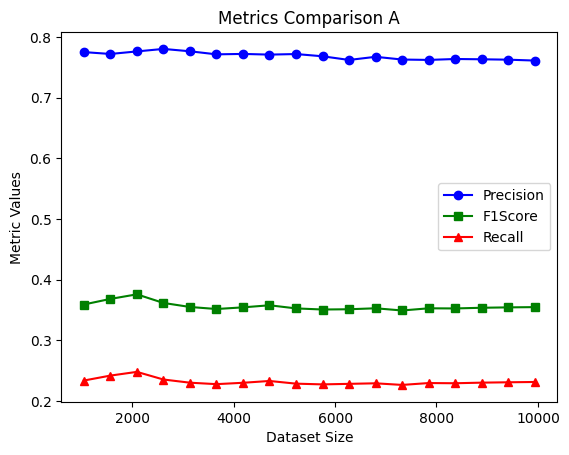

In [ ]:
plt.plot(x, prA2, label='Precision', color='blue', marker='o')
plt.plot(x, f1A2, label='F1Score', color='green', marker='s')
plt.plot(x, reA2, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Dataset Size vs Metrics - Model A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

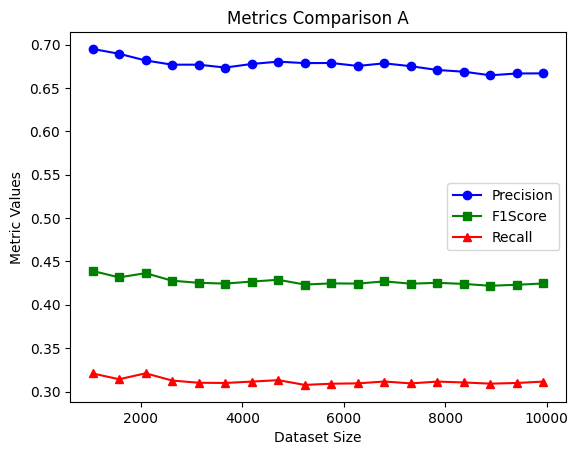

In [ ]:
plt.plot(x, prB2, label='Precision', color='blue', marker='o')
plt.plot(x, f1B2, label='F1Score', color='green', marker='s')
plt.plot(x, reB2, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Dataset Size vs Metrics - Model B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

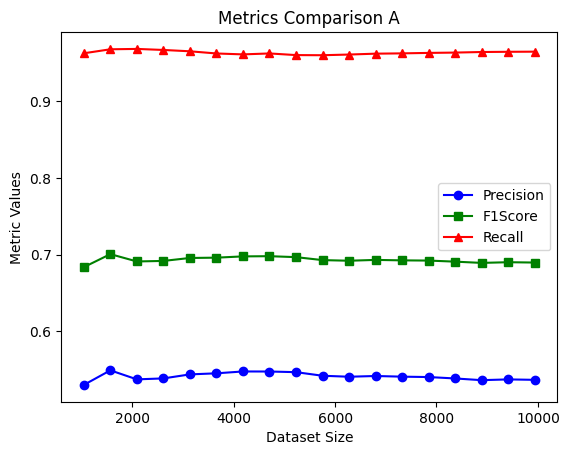

In [ ]:
plt.plot(x, prC2, label='Precision', color='blue', marker='o')
plt.plot(x, f1C2, label='F1Score', color='green', marker='s')
plt.plot(x, reC2, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Dataset Size vs Metrics - Model C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

###North Vs South Comparision

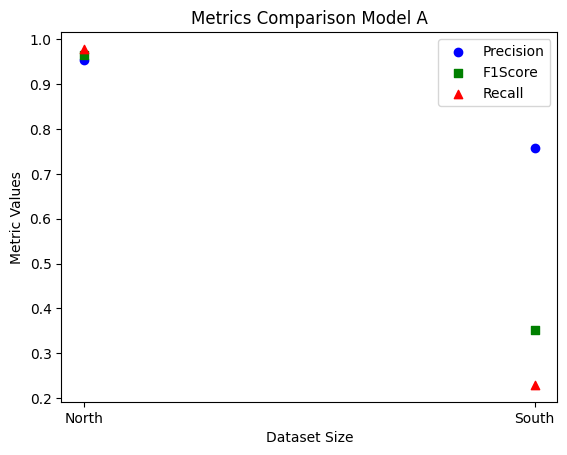

In [ ]:
plt.scatter(['North','South'], prStatsA, label='Precision', color='blue', marker='o')
plt.scatter(['North','South'], f1StatsA, label='F1Score', color='green', marker='s')
plt.scatter(['North','South'], reStatsA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('North Vs South - Model A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

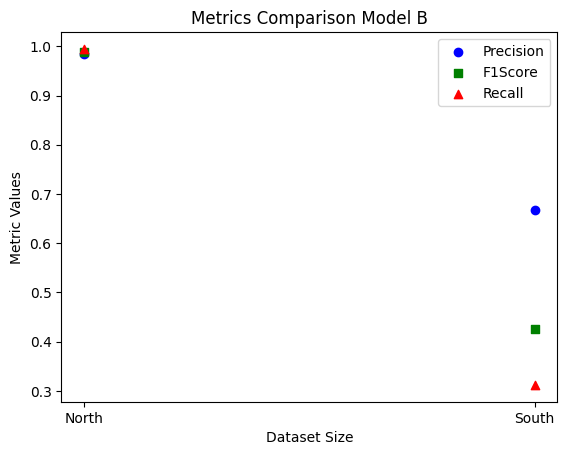

In [ ]:
plt.scatter(['North','South'], prStatsB, label='Precision', color='blue', marker='o')
plt.scatter(['North','South'], f1StatsB, label='F1Score', color='green', marker='s')
plt.scatter(['North','South'], reStatsB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('North Vs South - Model B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

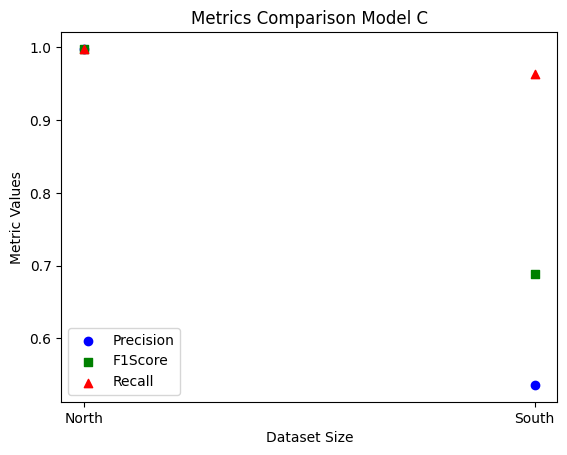

In [ ]:
plt.scatter(['North','South'], prStatsC, label='Precision', color='blue', marker='o')
plt.scatter(['North','South'], f1StatsC, label='F1Score', color='green', marker='s')
plt.scatter(['North','South'], reStatsC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('North Vs South - Model C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()